In [1]:
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from textblob import TextBlob

import altair as alt

import requests
from bs4 import BeautifulSoup
import pandas as pd


---

## Web scraping and analysis

This includes some code to web scraping. We will use a package called `BeautifulSoup` to collect the data from the web. collecting data and saving it into a local `.csv`.

### Scraping data from Skytrax

If you visit [https://www.airlinequality.com] you can see that there is a lot of data there. For this task, we are only interested in reviews related to British Airways and the Airline itself.

If you navigate to this link: [https://www.airlinequality.com/airline-reviews/british-airways] you will see this data. Now, we can use `Python` and `BeautifulSoup` to collect all the links to the reviews and then to collect the text data on each of the individual review links.

In [2]:
base_url = "https://www.airlinequality.com/airline-reviews/british-airways"
pages = 10
page_size = 100

reviews = []

for i in range(1, pages + 1):

    print(f"Scraping page {i}")

    # Create URL to collect links from paginated data
    url = f"{base_url}/page/{i}/?sortby=post_date%3ADesc&pagesize={page_size}"

    # Collect HTML data from this page
    response = requests.get(url)

    # Parse content
    content = response.content
    parsed_content = BeautifulSoup(content, 'html.parser')
    for para in parsed_content.find_all("div", {"class": "text_content"}):
        reviews.append(para.get_text())

    print(f"   ---> {len(reviews)} total reviews")

Scraping page 1
   ---> 100 total reviews
Scraping page 2
   ---> 200 total reviews
Scraping page 3
   ---> 300 total reviews
Scraping page 4
   ---> 400 total reviews
Scraping page 5
   ---> 500 total reviews
Scraping page 6
   ---> 600 total reviews
Scraping page 7
   ---> 700 total reviews
Scraping page 8
   ---> 800 total reviews
Scraping page 9
   ---> 900 total reviews
Scraping page 10
   ---> 1000 total reviews


In [3]:
df = pd.DataFrame()
df["reviews"] = reviews
df.head()

,reviews
0,Not Verified | LHR T5 BA Gold Wing worked wel...
1,Not Verified | Very good service on this rout...
2,✅ Trip Verified | Flight mainly let down by ...
3,✅ Trip Verified | Another awful experience b...
4,"✅ Trip Verified | The service was rude, full..."


# Save data to csv

In [4]:
df.to_csv("data/BA_reviews.csv")

Now we have dataset for this task! The loops above collected 1000 reviews by iterating through the paginated pages on the website. - if you want to collect more data, try increasing the number of pages!

 The next thing that we will do is clean this data to remove any unnecessary text from each of the rows. For example, "✅ Trip Verified" can be removed from each row if it exists, as it's not relevant to what we want to investigate.

# Load data

In [5]:
df=pd.read_csv("data/BA_reviews.csv")

# Drop unwanted Column

In [6]:
df.drop(columns=["Unnamed: 0"],inplace=True)

# Reset the index to create a new index column

In [7]:
df = df.reset_index()

In [8]:
df.head(5)

,index,reviews
0,0,Not Verified | LHR T5 BA Gold Wing worked wel...
1,1,Not Verified | Very good service on this rout...
2,2,✅ Trip Verified | Flight mainly let down by ...
3,3,✅ Trip Verified | Another awful experience b...
4,4,"✅ Trip Verified | The service was rude, full..."


# check - null value

In [9]:
df.isnull().sum()

,0
index,0
reviews,0


# remove `"✅ Trip Verified | ","Not Verified | "`

In [10]:
def clean_review(text):
    text = text.replace("✅ Trip Verified | ", "")
    text = text.replace("Not Verified | ", "")
    return text

df['reviews'] = df['reviews'].apply(clean_review)


# We’ll prep the text data by doing the following:

*   Lowercasing
*   Removing punctuation
*   Removing stopwords

## Download NLTK data

In [11]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

# Function to clean text

In [12]:
def clean_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))  # remove punctuation
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    return ' '.join(tokens)

In [13]:
df['cleaned'] = df['reviews'].apply(clean_text)

# WordCloud

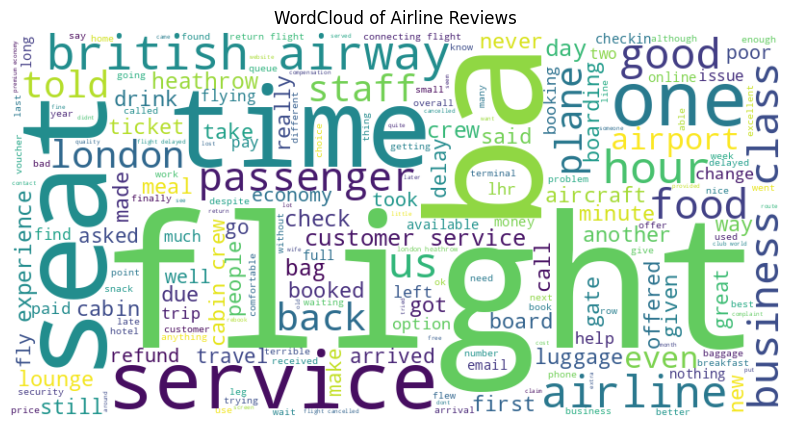

In [14]:
all_text = ' '.join(df['cleaned'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud of Airline Reviews")
plt.show()

# Sentiment Analysis

In [15]:
df['sentiment'] = df['reviews'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Sentiment score:

In [16]:
print("Average sentiment score:", df['sentiment'].mean())

Average sentiment score: 0.057379818917054425


# Simple sentiment summary

In [18]:
print(df[['index', 'sentiment']])

     index  sentiment
0        0   0.402794
1        1  -0.120648
2        2   0.207461
3        3  -0.320000
4        4  -0.045833
..     ...        ...
995    995   0.056667
996    996  -0.316667
997    997   0.035714
998    998   0.272614
999    999  -0.191528

[1000 rows x 2 columns]


# Create a new column 'sentiment_category' based on the 'sentiment' column

In [19]:
df['sentiment_category'] = df['sentiment'].apply(lambda x: 'Positive' if x > 0 else 'Negative')

In [20]:
df.head(5)

,index,reviews,cleaned,sentiment,sentiment_category
0,0,LHR T5 BA Gold Wing worked well. Pleasant che...,lhr t5 ba gold wing worked well pleasant check...,0.402794,Positive
1,1,Very good service on this route BA2710 30th M...,good service route ba2710 30th march cabin cre...,-0.120648,Negative
2,2,Flight mainly let down by a disagreeable fli...,flight mainly let disagreeable flight attendan...,0.207461,Positive
3,3,Another awful experience by British Airways....,another awful experience british airways fligh...,-0.320000,Negative
4,4,"The service was rude, full of attitude to me...",service rude full attitude food poorly service...,-0.045833,Negative


# Group by sentiment category and count the number of reviews in each category

In [21]:
sentiment_counts = df.groupby('sentiment_category').size().reset_index(name='count')

# Create a bar chart showing the count of positive and negative sentiments

In [22]:
alt.Chart(sentiment_counts).mark_bar().encode(
    x='sentiment_category',
    y='count',
    color='sentiment_category'  # Color-code the bars
)


alt.Chart(...)

# Group by sentiment category and count the number of reviews in each category

In [23]:
sentiment_counts = df.groupby('sentiment_category').size().reset_index(name='count')

sentiment_counts


,sentiment_category,count
0,Negative,387
1,Positive,613


# Word cloud, "positive sentiment" and exclude specified words

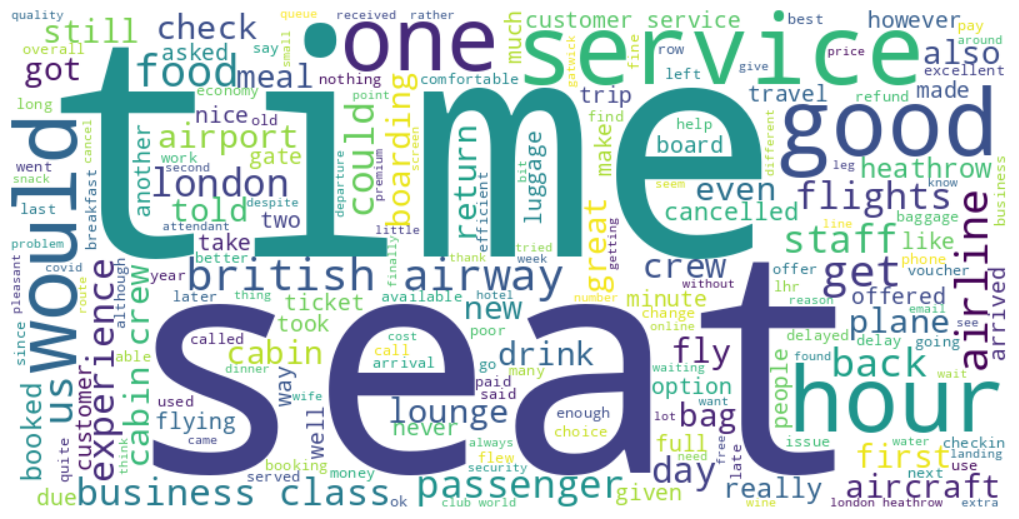

In [24]:
positive_reviews = df[(df['sentiment_category'] == 'Positive')]
text = " ".join(review for review in positive_reviews.cleaned)
stopwords = ['flight', 'ba', 'british airways','british airway']

wordcloud = WordCloud(width=800, height=400, stopwords=stopwords, background_color="white").generate(text)

plt.figure(figsize=(10, 5), facecolor=None)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

# Word cloud, "Negative sentiment" and exclude specified words

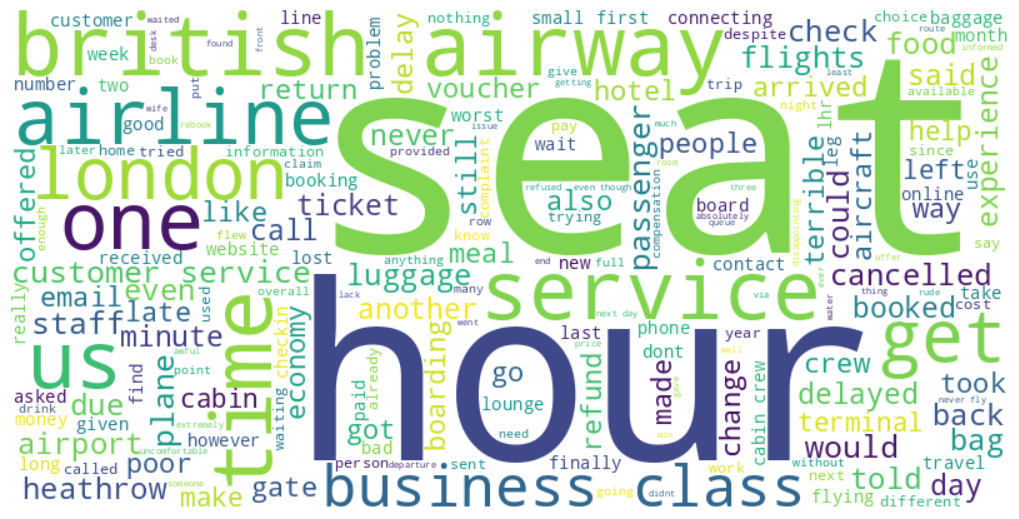

In [25]:
positive_reviews = df[(df['sentiment_category'] == 'Negative')]
text = " ".join(review for review in positive_reviews.cleaned)
stopwords = ['flight', 'ba', 'british airways','british airway']

wordcloud = WordCloud(width=800, height=400, stopwords=stopwords, background_color="white").generate(text)

plt.figure(figsize=(10, 5), facecolor=None)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()